# Prepare the data

1. Load the fine-tuning data

In [9]:
import json

file_path = "/content/TRAIN_MODEL/data/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

2. Load the tokenizer

In [10]:
import sys
sys.path.append('..')

In [11]:
from minbpe.regex import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="/content/TRAIN_MODEL/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

3. Tokenize the sequences

In [12]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

131

4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a You message and end with an Assistant message.

In [15]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
    split_index -= 1

# Ensure split_index is not 0 to avoid empty train_data
if split_index == 0:
  # Find the first instance of an Assistant message to split
  for i in range(initial_split_index, len(data)):
    if data[i].startswith('<|startoftext|>Assistant'):
      split_index = i + 1
      break
  # If no Assistant message is found after initial_split_index, split at initial_split_index
  if split_index == 0:
      split_index = initial_split_index


train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 2

Validation set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 1


We got the index that we should use to split the data. Now, let's split the tokenized data

In [16]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the You and Assistant turns into one sequence. We will make sure that the resulting sequence does not exceed the block_size.

In [17]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [18]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 48
Length after: 24

Validation data
Length before: 3
Length after: 1


We will merge the You and Assistant parts into one sequence. Then, we will try to combine multiple sequences of You and Assistant into a single input, but only if the sequence length stays smaller than the block size.

In [19]:
def merge_conversation_turns(combined_data: list[list[int]], block_size: int) -> list[list[int]]:
    new_data = []
    current_sequence = []

    for sequence in combined_data:
        if len(current_sequence) + len(sequence) <= block_size:
            current_sequence.extend(sequence)
        else:
            if current_sequence:
                new_data.append(current_sequence)
            current_sequence = sequence.copy()

    # Add the last block if it's not empty
    if current_sequence:
        new_data.append(current_sequence)

    return new_data


merged_train_data = merge_conversation_turns(
    combined_data=combined_train_data,
    block_size=block_size
)
merged_val_data = merge_conversation_turns(
    combined_data=combined_val_data,
    block_size=block_size
)


In [20]:
len(combined_train_data), len(merged_train_data)

(24, 10)

Let's convert each sequence of tokens into a tensor.

In [22]:
import torch

def pad_sequence(sequence, block_size, padding_value=0):
    """Pads a sequence to the given block_size."""
    if len(sequence) > block_size:
        return sequence[:block_size]
    else:
        return sequence + [padding_value] * (block_size - len(sequence))

padded_train_data = [pad_sequence(seq, block_size) for seq in combined_train_data]
padded_val_data = [pad_sequence(seq, block_size) for seq in combined_val_data]

train_data = torch.tensor(padded_train_data)
val_data = torch.tensor(padded_val_data)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start

In [23]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=merged_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=merged_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape


(torch.Size([10, 256]), torch.Size([1, 256]))

In [24]:
train_data_tensor[0]

tensor([1024,   80,  270,  115,  281,   32,   49, 1025,   72,  101,  121,   10,
          72,  111,  119,   32,  296,  101,   32,  121,  324,   63,   10,   91,
         520,   47,   48,   50,   47,   50,   48,   50,   53,   44,   32,   57,
          58,   49,   56,  909,   77,   93,   32,  126,   32,   80,  270,  115,
         281,   32,   50,   58,   32,   72,  101,  121,   33,  348,  843,  109,
          32,  103,  378,  100,   44,   32,  796,  360,   32,  636,  324,  116,
          32,  121,  324,   63,   10,   91,  520,   47,   48,   50,   47,   50,
          48,   50,   53,   44,   32,   57,   58,   50,   48,  909,   77,   93,
          32,  126,   32,   80,  270,  115,  281,   32,   49,   58,  348,  843,
         109,   32,  103,  378,  100,   32,  116,  378,   44,   32,  106,  117,
         333,   32,   97,   32,   98,  438,   32,  685,  346,  100, 1026, 1024,
          80,  270,  115,  281,   32,   50, 1025,   76,  281,  103,   32,  110,
         105,  536,  116,   63,   10,   

In [25]:
val_data_tensor[0]

tensor([1024,   80,  270,  115,  281,   32,   49, 1025,   89,  324,   32,  866,
         346,   63,  348,   32,   99,  276,   32,  100,  313,  118,  101,   32,
         353,   32,  121,  324,  843,  346,   32,  685,  346,  100, 1026, 1024,
          80,  270,  115,  281,   32,   50, 1025,   78,   97,  104,   44,  348,
          32,  103,  565,   32,  374,  115, 1026, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 10

5. Creat the data loaders

In [26]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [27]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([10, 256]), torch.Size([10, 256]))

#Fine-tuning

1. Load the saved checkpoint

In [29]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 516
n_head = 12
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.474826 M parameters


In [30]:
checkpoint_path = "/content/TRAIN_MODEL/output/checkpoint_0.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly

In [32]:
input_tokens = tokenizer.encode(" is my name on the list ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

 is my name on the list Annames that 26 cocomes fice scon The was ded odebecause If there are carryover in carryover trough nexted , fine class Group ever lass abeg Who day? Yes ooo our 170
Please memprigroup ad seme


2. Estimate loss

In [33]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

3. Save checkpoints

In [34]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

4. Training loop

In [35]:
max_iters = 20
eval_interval = 5
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"/content/TRAIN_MODEL/output/checkpoint2.0_{iteration}.pth"
    )


W0621 13:11:26.006000 821 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


iteration 0 / step 0: train loss 5.9129, val loss 6.0196
iteration 1 / step 0: train loss 4.3924, val loss 4.5751
iteration 2 / step 0: train loss 3.8807, val loss 3.8717
iteration 3 / step 0: train loss 3.4363, val loss 3.5226
iteration 4 / step 0: train loss 3.1353, val loss 3.2649
iteration 5 / step 0: train loss 2.8900, val loss 3.0888
iteration 6 / step 0: train loss 2.6542, val loss 2.9360
iteration 7 / step 0: train loss 2.4560, val loss 2.8367
iteration 8 / step 0: train loss 2.3040, val loss 2.7819
iteration 9 / step 0: train loss 2.1570, val loss 2.7400
iteration 10 / step 0: train loss 2.0193, val loss 2.6904
iteration 11 / step 0: train loss 1.9004, val loss 2.6164
iteration 12 / step 0: train loss 1.7899, val loss 2.5286
iteration 13 / step 0: train loss 1.6871, val loss 2.4515
iteration 14 / step 0: train loss 1.5916, val loss 2.3939
iteration 15 / step 0: train loss 1.5070, val loss 2.3568
iteration 16 / step 0: train loss 1.4351, val loss 2.3314
iteration 17 / step 0: t

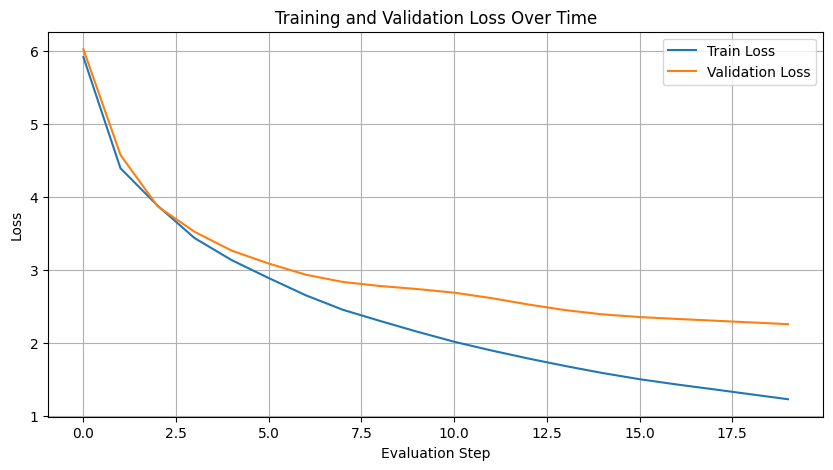

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [40]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "where you dey"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        break

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")


You: where you dey
Assistant: No, you wos Thanly someone shan friendan come wiri you to se lve thrie ch Ea new a it?gwu Maurice Lotankaled No: I’m project!GODSPPerson 2CYNTHHow semester where, I Are'm ll adrigood, I mint doing the best uses ahere problem waiting!, I’t s took, I’m here on s that?
